# 07 — Análisis de Errores por Segmentos

**Objetivo:** Investigar *dónde* y *por qué* nuestro mejor modelo se equivoca. Se analizan los errores de predicción (residuales) en diferentes segmentos de los datos para identificar posibles debilidades o sesgos.

**Entradas:**
- `artifacts/oof_predictions.csv`: Las predicciones Out-of-Fold generadas y guardadas por el `stage` `train`.
- `data/feast/training_set.parquet`: Las características originales para poder segmentar los datos.

**Salidas:**
- **Tablas de Error por Segmento:** Resúmenes que muestran el error promedio para diferentes categorías (ej. por tipo de póliza, nivel de educación) o rangos de valores numéricos (ej. por ingresos anuales).
- **Gráfico de Dispersión (Actual vs. Predicho):** Una visualización en el espacio logarítmico para evaluar el ajuste general del modelo.

**Dependencias:**
- Requiere haber ejecutado el `stage` `train` con la modificación que guarda el artefacto `oof_predictions.csv`.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
from src.config import ARTIFACTS_DIR, FEAST_TRAINSET, TARGET
from src.logging_utils import setup_logger

logger = setup_logger("error_analysis")
sns.set(style="whitegrid")
logger.info("Notebook 07_error_analysis iniciado.")

2025-08-24 19:47:05.588 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops


2025-08-24 19:47:05.599 | INFO     | __main__:<module>:15 - Notebook 07_error_analysis iniciado.
2025-08-24 19:47:05 | INFO | Notebook 07_error_analysis iniciado.


In [5]:
FEAST_TRAINSET

'data/feast/training_set.parquet'

In [4]:
# Cargar datos y predicciones OOF
logger.info("Cargando predicciones Out-of-Fold y features originales...")

# Usamos la ruta relativa correcta desde la carpeta notebooks/
OOF_PATH = f"{ARTIFACTS_DIR}/oof_predictions.csv"
FEATURES_PATH = f"../{FEAST_TRAINSET}"

try:
    oof_df = pd.read_csv(OOF_PATH)
    features_df = pd.read_parquet(FEATURES_PATH)
    
    # Elegir el mejor modelo para el análisis (el nombre de la columna en oof_df)
    best_model_name = 'lgbm' 
    
    # Calcular el error en log-space
    res = pd.DataFrame({
        "y_true": oof_df[TARGET],
        "y_pred": oof_df[best_model_name],
        "log_error": np.log1p(oof_df[TARGET]) - np.log1p(np.maximum(0, oof_df[best_model_name]))
    })

    # Unir con las features originales para poder segmentar
    analysis_df = res.join(features_df)
    
    logger.info("Datos para análisis preparados.")
    display(analysis_df.head())

except FileNotFoundError as e:
    logger.error(f"No se encontró el archivo necesario: {e}. ¿Ejecutaste 'dvc repro train'?")
    analysis_df = pd.DataFrame()

2025-08-24 19:49:28.386 | INFO     | __main__:<module>:2 - Cargando predicciones Out-of-Fold y features originales...
2025-08-24 19:49:28 | INFO | Cargando predicciones Out-of-Fold y features originales...
2025-08-24 19:49:28.930 | INFO     | __main__:<module>:26 - Datos para análisis preparados.
2025-08-24 19:49:28 | INFO | Datos para análisis preparados.


,y_true,y_pred,log_error,id,event_timestamp,Premium Amount,Age,Annual Income,Number of Dependents,Health Score,...,Location_Suburban,Location_Urban,Location_Unknown,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Exercise Frequency_Unknown,Property Type_Condo,Property Type_House,Property Type_Unknown
0,1328.0,1020.994424,0.262671,1112515,2019-08-17 15:21:39.080371+00:00,1328.0,19.0,498.0,2.0,27.068329,...,False,False,False,False,True,False,False,True,False,False
1,20.0,1593.536815,-4.329816,364240,2019-08-17 15:21:39.080440+00:00,20.0,45.0,102043.0,0.0,36.477553,...,False,False,False,False,False,False,False,True,False,False
2,730.0,1163.040979,-0.465239,957582,2019-08-17 15:21:39.080440+00:00,730.0,33.0,7894.0,1.0,35.986064,...,True,False,False,False,True,False,False,True,False,False
3,2979.0,1184.981317,0.921353,994714,2019-08-17 15:21:39.080440+00:00,2979.0,58.0,47253.0,2.0,24.981910,...,False,True,False,False,True,False,False,True,False,False
4,688.0,1355.595951,-0.677493,212928,2019-08-17 15:21:39.080440+00:00,688.0,40.0,3050.0,3.0,18.849237,...,True,False,False,False,False,False,False,False,False,False


In [8]:
# Función para análisis por segmentos
def slice_stats(col_name: str):
    """Calcula estadísticas de error para los segmentos de una columna."""
    if col_name in analysis_df.columns:
        # Usamos qcut para binnear variables numéricas continuas
        if pd.api.types.is_numeric_dtype(analysis_df[col_name]) and analysis_df[col_name].nunique() > 20:
            analysis_df['segment'] = pd.qcut(analysis_df[col_name], q=10, duplicates='drop')
            group_col = 'segment'
        else:
            group_col = col_name
            
        stats = (analysis_df
         .groupby(group_col, observed=False)["log_error"]
         .agg(["count", "mean", "std"])
         .sort_values("mean", key=lambda s: s.abs(), ascending=False))
        return stats
    return f"Columna '{col_name}' no encontrada."

In [9]:
# Ejecutar análisis por segmentos
if not analysis_df.empty:
    cols_to_analyze = [
        "Age", "Annual Income", "Policy Type", 
        "Education Level", "Location_Urban", "Smoking Status_Yes"
    ]
    for col in cols_to_analyze:
        print(f"\n--- Análisis de Error por '{col}' ---")
        display(slice_stats(col))


--- Análisis de Error por 'Age' ---


,count,mean,std
segment,,,
"(60.0, 64.0]",102340,-0.388377,1.069625
"(17.999, 22.0]",124480,-0.387160,1.064479
"(32.0, 37.0]",127169,-0.387092,1.064741
"(55.0, 60.0]",126731,-0.386562,1.063643
"(50.0, 55.0]",126610,-0.386293,1.063895
"(22.0, 27.0]",121153,-0.384462,1.065325
"(37.0, 41.0]",119087,-0.383565,1.063819
"(41.0, 46.0]",127091,-0.383322,1.062503
"(46.0, 50.0]",100593,-0.381972,1.058837



--- Análisis de Error por 'Annual Income' ---


,count,mean,std
segment,,,
"(79448.1, 138543.02]",120000,-0.542744,1.231503
"(49851.2, 79448.1]",120000,-0.541562,1.225646
"(497.999, 2699.0]",120009,-0.459014,1.223116
"(2699.0, 6054.0]",120058,-0.401628,1.135391
"(17430.0, 23911.0]",142470,-0.376533,1.015149
"(38729.0, 49851.2]",119972,-0.323929,0.967684
"(28981.0, 38729.0]",120003,-0.304976,0.932256
"(6054.0, 11916.0]",120014,-0.298826,0.926023
"(23911.0, 28981.0]",97546,-0.292327,0.925765



--- Análisis de Error por 'Policy Type' ---


,count,mean,std
Policy Type,,,
1,399600,-0.385144,1.064630
2,401846,-0.385045,1.062459
0,398554,-0.384613,1.064350



--- Análisis de Error por 'Education Level' ---


,count,mean,std
Education Level,,,
2,303818,-0.386795,1.065649
0,289441,-0.384675,1.064513
1,303234,-0.384387,1.064435
3,303507,-0.383867,1.060669



--- Análisis de Error por 'Location_Urban' ---


,count,mean,std
Location_Urban,,,
False,802489,-0.385527,1.063846
True,397511,-0.383738,1.063736



--- Análisis de Error por 'Smoking Status_Yes' ---


,count,mean,std
Smoking Status_Yes,,,
False,598127,-0.385827,1.064775
True,601873,-0.384048,1.062849


2025-08-24 19:58:42.243 | INFO     | __main__:<module>:3 - Generando gráfico de dispersión Actual vs. Predicho.
2025-08-24 19:58:42 | INFO | Generando gráfico de dispersión Actual vs. Predicho.


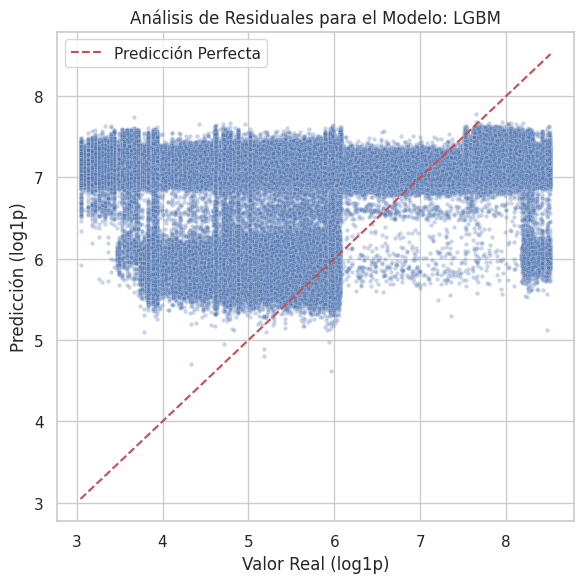

In [10]:
# Gráfico de Dispersión (Actual vs. Predicho)
if not analysis_df.empty:
    logger.info("Generando gráfico de dispersión Actual vs. Predicho.")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        x=np.log1p(analysis_df["y_true"]), 
        y=np.log1p(np.maximum(0, analysis_df["y_pred"])), 
        s=10, alpha=0.3
    )
    # Línea de referencia perfecta
    perfect_line = [
        min(np.log1p(analysis_df["y_true"])), 
        max(np.log1p(analysis_df["y_true"]))
    ]
    plt.plot(perfect_line, perfect_line, "r--", label="Predicción Perfecta")
    
    plt.xlabel("Valor Real (log1p)")
    plt.ylabel("Predicción (log1p)")
    plt.title(f"Análisis de Residuales para el Modelo: {best_model_name.upper()}")
    plt.legend()
    plt.tight_layout()
    plt.show()